# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical unsupervised link prediction techniques.

### 1. Import Packages

In [47]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'util.autoencoder' from 'c:\\Users\\pbedi\\Documents\\GitHub\\Network-Science_Challenge\\util\\autoencoder.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# basic stuff
from itertools import product, combinations
from collections import OrderedDict

# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data
import sknetwork

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from xgboost import XGBClassifier
import sknetwork

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a few minutes
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2, n2v_train=False)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Enriching train data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Do

Enriching validation data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Do

Enriching test data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Challenge\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Do

In [5]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching node features...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]
c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
Generating walks (CPU: 1): 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]
c:\Users\pbedi\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Create PyTorch Geometric dataset...


In [6]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.2, 5, 0.2, 0))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(sim_scaled = (train_sim.sim.values - train_sim.sim.values.min()) / (train_sim.sim.values.max() - train_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(sim_scaled = (val_sim.sim.values - val_sim.sim.values.min()) / (val_sim.sim.values.max() - val_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(sim_scaled = (test_sim.sim.values - test_sim.sim.values.min()) / (test_sim.sim.values.max() - test_sim.sim.values.min()))
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test           = loadData.split_frame(test_tf)

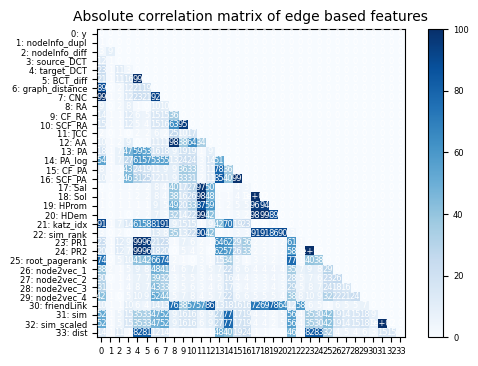

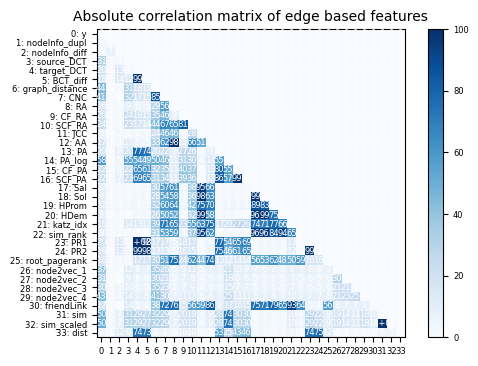

In [7]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

### 3. Unsupervised Link Prediction

In [8]:
def compute_score(df, cols, method, thresh):
    # we assume that all metrics get better with increasing values!
    
    df_ = df[list(cols)]
    
    if method == "rank_avg":
        df_ = df_.rank(pct = True).mean(axis = 1)  
    elif method == "avg":
        df_ = df_.mean(axis = 1)
    elif method == "whitened_sigmoid_avg":
        df_ = pd.DataFrame({col: sknetwork.linkpred.whitened_sigmoid(df_[col].to_numpy()) for col in df_.columns})
        df_ = df_.mean(axis = 1)
        
    if thresh == "top50%":
        y_hat = (df_ > df_.median()).astype(int)
    elif thresh == "thresh":
        y_hat = (df_ > 0.5).astype(int)
    elif thresh == "return_probas":
        y_hat = df_.rank(pct = True)
        
    return y_hat

We only consider a subset of somewhat decorrelated metrics (otherwise this search will run too long). For example, Sorensen Index is highly correlated (.99) with Salton Index, thus it is enough to only include one of them in our below search (same for Adamic Adar and Resource Allocation, but not for Adamic Adar and SCF Resource Allocation).

In [7]:
# which cols we want to use for link prediction
res = OrderedDict()

cols = ["CNC", "SCF_RA", "JCC", "AA", "PA_log", "SoI", "HProm", # local methods
        "katz_idx", "sim_rank", "root_pagerank", "node2vec_1", "node2vec_4", # global methods
        "friendLink"]                                           # quasi-local methods

methods = ["rank_avg", "avg", "whitened_sigmoid_avg"]
threshs = ["top50%", "thresh"]

# generate all combinations of columns in cols
sampled_cols = []
for n in range(2, len(cols) + 1):
    sampled_cols += list([c for c in combinations(cols, n)])

for s, m, t in tqdm(product(sampled_cols, methods, threshs)):
    y_train_hat = compute_score(X_train, s, m, t)
    y_val_hat   = compute_score(X_val, s, m, t)
    trn_acc     = accuracy_score(y_train, y_train_hat)
    val_acc     = accuracy_score(y_val, y_val_hat)

    res[(s, m, t)] = {"trn_acc": trn_acc, "val_acc": val_acc}

49068it [06:00, 135.94it/s]


In [8]:
ordered_res = (sorted(res.items(), key = lambda kv: kv[1]["val_acc"], reverse = True))

for (col, m, t), val_dict in ordered_res[0:10]:
    print(f"using {col}, {m}, {t}")
    print(f"Train Accuracy {round(val_dict['trn_acc'], 5)}, Val Accuracy {round(val_dict['val_acc'], 5)}\n")

using ('JCC', 'AA', 'PA_log', 'root_pagerank'), rank_avg, thresh
Train Accuracy 0.90671, Val Accuracy 0.7807

using ('JCC', 'PA_log', 'SoI', 'root_pagerank'), rank_avg, thresh
Train Accuracy 0.90671, Val Accuracy 0.7807

using ('JCC', 'PA_log', 'HProm', 'root_pagerank'), rank_avg, thresh
Train Accuracy 0.90671, Val Accuracy 0.7807

using ('AA', 'PA_log', 'SoI', 'root_pagerank'), rank_avg, thresh
Train Accuracy 0.90671, Val Accuracy 0.7807

using ('AA', 'PA_log', 'HProm', 'root_pagerank'), rank_avg, thresh
Train Accuracy 0.90671, Val Accuracy 0.7807

using ('PA_log', 'SoI', 'HProm', 'root_pagerank'), rank_avg, thresh
Train Accuracy 0.90671, Val Accuracy 0.7807

using ('SCF_RA', 'JCC', 'AA', 'PA_log', 'katz_idx'), avg, top50%
Train Accuracy 0.74236, Val Accuracy 0.78022

using ('SCF_RA', 'AA', 'PA_log', 'SoI', 'katz_idx'), avg, top50%
Train Accuracy 0.74236, Val Accuracy 0.78022

using ('SCF_RA', 'JCC', 'AA', 'PA_log', 'katz_idx', 'friendLink'), avg, top50%
Train Accuracy 0.74236, Val Ac

In [66]:
# use best settings
s = ['JCC', 'AA', 'PA_log', 'SoI', 'HProm', 'root_pagerank']
m = "rank_avg"
t = "thresh"
y_train_hat = compute_score(X_train, s, m, t)
y_val_hat   = compute_score(X_val, s, m, t)
y_test_hat  = compute_score(X_test, s, m, t)

In [67]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      4198
           1       0.89      0.92      0.91      4174

    accuracy                           0.91      8372
   macro avg       0.91      0.91      0.91      8372
weighted avg       0.91      0.91      0.91      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1050
           1       0.83      0.70      0.76      1043

    accuracy                           0.78      2093
   macro avg       0.78      0.78      0.78      2093
weighted avg       0.78      0.78      0.78      2093

Roc_auc score
-------------------------------------------------------
0.77806008309364

Confusion matrix
-------------------------------------------------------
[[895 155]
 [309 734]]


In [23]:
# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)

In [24]:
# look at predicted labels
save_test.value_counts()

Predicted
0            2073
1            1425
dtype: int64

let us now combine our local ensemble model with the embedding similarities from our autoencoder

doesn't really work well...

In [29]:
# now let's try to average these predictions with the results from our autoencoder
s = ['JCC', 'AA', 'PA_log', 'root_pagerank']
m = "rank_avg"
t = "return_probas"
y_train_hat = compute_score(X_train, s, m, t)
y_val_hat   = compute_score(X_val, s, m, t)
y_test_hat  = compute_score(X_test, s, m, t)

In [30]:
# take max
y_train_hat = pd.concat([y_train_hat, train_tf.sim.rank(pct = True)], axis = 1).max(axis = 1)
y_train_hat = (y_train_hat > y_train_hat.median()).astype(int)

y_val_hat = pd.concat([y_val_hat, val_tf.sim.rank(pct = True)], axis = 1).max(axis = 1)
y_val_hat = (y_val_hat > y_val_hat.median()).astype(int)

y_test_hat = pd.concat([y_test_hat, test_tf.sim.rank(pct = True)], axis = 1).max(axis = 1)
y_test_hat = (y_test_hat > y_test_hat.median()).astype(int)

In [31]:
# add scaled similarities
alpha = 0.66
beta  = 0.34

y_train_hat = (alpha * y_train_hat + beta * train_tf.sim.rank(pct = True))
y_train_hat = (y_train_hat > y_train_hat.median()).astype(int)

y_val_hat = (alpha * y_val_hat + beta * val_tf.sim.rank(pct = True))
y_val_hat = (y_val_hat > y_val_hat.median()).astype(int)

y_test_hat = (alpha * y_test_hat + beta * test_tf.sim.rank(pct = True))
y_test_hat = (y_test_hat > y_test_hat.median()).astype(int)

In [32]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4198
           1       0.79      0.79      0.79      4174

    accuracy                           0.79      8372
   macro avg       0.79      0.79      0.79      8372
weighted avg       0.79      0.79      0.79      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1050
           1       0.76      0.76      0.76      1043

    accuracy                           0.76      2093
   macro avg       0.76      0.76      0.76      2093
weighted avg       0.76      0.76      0.76      2093

Roc_auc score
-------------------------------------------------------
0.7596772131671461

Confusion matrix
-------------------------------------------------------
[[797 253]
 [250 793]]
